# Baseline model based on anatomy features

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn

In [3]:
from problem import get_train_data, get_test_data

data_train, labels_train = get_train_data(path=path)
data_test, labels_test = get_test_data(path=path)

In [4]:
data_train.shape, data_test.shape

((1127, 220), (23, 220))

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from problem import get_cv

def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

### Basic RF

In [98]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[[col for col in X_df.columns if col.startswith('anatomy')]]
        return X.drop(columns='anatomy_select')

    
from sklearn.ensemble import RandomForestClassifier

seed = 12345

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = RandomForestClassifier(max_depth=2, n_estimators=50, min_samples_leaf=2, random_state=seed)

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [100]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.773 +- 0.012
Validation score ROC-AUC: 0.601 +- 0.031 

Training score accuracy: 0.672 +- 0.007
Validation score accuracy: 0.574 +- 0.026


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s finished


Let's visualize feature importance:

In [101]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.feature_importances_.ravel()
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), feature_names[interesting_coefficients], rotation=90);

In [102]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [105]:
rf = pipe.named_steps['classifier'].clf

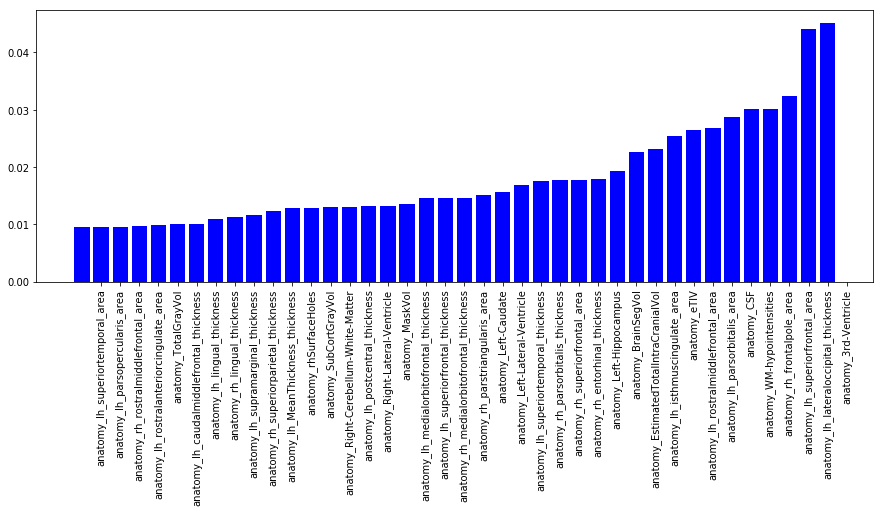

In [106]:
cols=[col for col in data_train.columns if col.startswith('anatomy')]

visualize_coefficients(rf, feature_names=cols, n_top_features=40)

In [148]:
n_top_features = 12
coef = rf.feature_importances_.ravel()
interesting_coefficients = np.argsort(coef)[-n_top_features:]

In [149]:
topk_feature_names = np.array(cols)[interesting_coefficients].tolist()

In [152]:
topk_feature_names

['anatomy_BrainSegVol',
 'anatomy_EstimatedTotalIntraCranialVol',
 'anatomy_lh_isthmuscingulate_area',
 'anatomy_eTIV',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_lh_parsorbitalis_area',
 'anatomy_CSF',
 'anatomy_WM-hypointensities',
 'anatomy_rh_frontalpole_area',
 'anatomy_lh_superiorfrontal_area',
 'anatomy_lh_lateraloccipital_thickness',
 'anatomy_3rd-Ventricle']

### Basic RF with filtered features 

In [169]:
topk_feature_names = ['anatomy_BrainSegVol',
 'anatomy_EstimatedTotalIntraCranialVol',
 'anatomy_lh_isthmuscingulate_area',
 'anatomy_eTIV',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_lh_parsorbitalis_area',
 'anatomy_CSF',
 'anatomy_WM-hypointensities',
 'anatomy_rh_frontalpole_area',
 'anatomy_lh_superiorfrontal_area',
 'anatomy_lh_lateraloccipital_thickness',
 'anatomy_3rd-Ventricle'
]


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[topk_feature_names]
        return X
    

seed = 17        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):        
        self.clf = RandomForestClassifier(max_depth=3, n_estimators=150, min_samples_leaf=2, random_state=seed)
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [170]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.767 +- 0.005
Validation score ROC-AUC: 0.662 +- 0.032 

Training score accuracy: 0.686 +- 0.009
Validation score accuracy: 0.614 +- 0.028


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.7s finished


### Basic GBT

In [198]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[[col for col in X_df.columns if col.startswith('anatomy')]]
        return X.drop(columns='anatomy_select')

    
from sklearn.ensemble import GradientBoostingClassifier

seed = 12

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = GradientBoostingClassifier(learning_rate=0.0051, max_depth=2, n_estimators=100, 
                                              subsample=0.4,
                                              random_state=seed)

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [199]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.818 +- 0.008
Validation score ROC-AUC: 0.627 +- 0.036 

Training score accuracy: 0.674 +- 0.010
Validation score accuracy: 0.577 +- 0.016


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.5s finished


Let's visualize feature importance:

In [200]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.feature_importances_.ravel()
    interesting_coefficients = np.argsort(coef)[-n_top_features:]
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + n_top_features), feature_names[interesting_coefficients], rotation=90);

In [201]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [239]:
gbt = pipe.named_steps['classifier'].clf

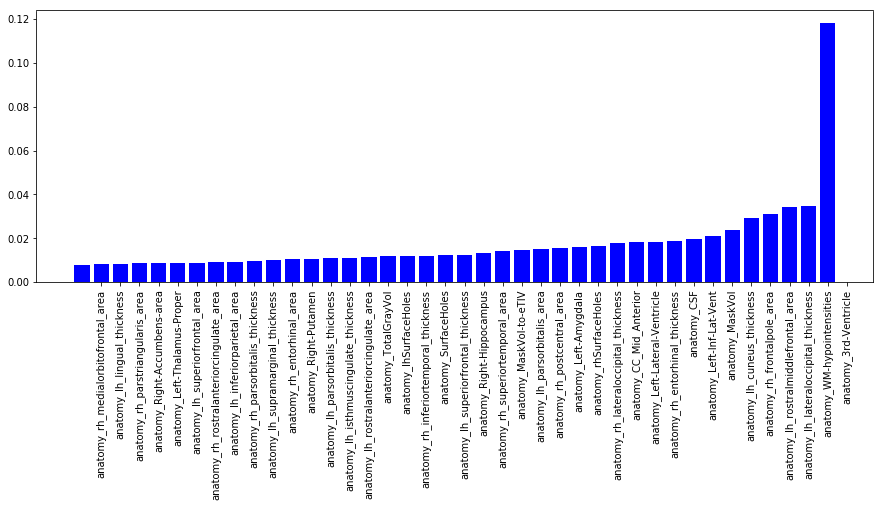

In [240]:
cols=[col for col in data_train.columns if col.startswith('anatomy')]

visualize_coefficients(gbt, feature_names=cols, n_top_features=40)

In [221]:
n_top_features = 12
coef = rf.feature_importances_.ravel()
interesting_coefficients = np.argsort(coef)[-n_top_features:]

In [222]:
topk_feature_names = np.array(cols)[interesting_coefficients].tolist()

In [223]:
topk_feature_names

['anatomy_CC_Mid_Anterior',
 'anatomy_Left-Lateral-Ventricle',
 'anatomy_rh_entorhinal_thickness',
 'anatomy_CSF',
 'anatomy_Left-Inf-Lat-Vent',
 'anatomy_MaskVol',
 'anatomy_lh_cuneus_thickness',
 'anatomy_rh_frontalpole_area',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_lh_lateraloccipital_thickness',
 'anatomy_WM-hypointensities',
 'anatomy_3rd-Ventricle']

### Basic GBT with filtered features 

In [234]:


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[topk_feature_names]
        return X
    

seed = 17        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):        
        self.clf = GradientBoostingClassifier(learning_rate=0.001, max_depth=2, n_estimators=150, 
                                              subsample=0.4,
                                              random_state=seed)
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [235]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.760 +- 0.004
Validation score ROC-AUC: 0.671 +- 0.026 

Training score accuracy: 0.685 +- 0.008
Validation score accuracy: 0.620 +- 0.018


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.9s finished


### Basic ensembling of RF + GBT

In [276]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
    

seed = 17

rf_features = ['anatomy_BrainSegVol',
 'anatomy_EstimatedTotalIntraCranialVol',
 'anatomy_lh_isthmuscingulate_area',
 'anatomy_eTIV',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_lh_parsorbitalis_area',
 'anatomy_CSF',
 'anatomy_WM-hypointensities',
 'anatomy_rh_frontalpole_area',
 'anatomy_lh_superiorfrontal_area',
 'anatomy_lh_lateraloccipital_thickness',
 'anatomy_3rd-Ventricle'
]

gbt_features = ['anatomy_CC_Mid_Anterior',
 'anatomy_Left-Lateral-Ventricle',
 'anatomy_rh_entorhinal_thickness',
 'anatomy_CSF',
 'anatomy_Left-Inf-Lat-Vent',
 'anatomy_MaskVol',
 'anatomy_lh_cuneus_thickness',
 'anatomy_rh_frontalpole_area',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_lh_lateraloccipital_thickness',
 'anatomy_WM-hypointensities',
 'anatomy_3rd-Ventricle']


class Classifier(BaseEstimator):
    def __init__(self):
        self.rf = None
        self.gbt = None

    def fit(self, X, y):        
        
        self.rf = RandomForestClassifier(max_depth=3, n_estimators=150, 
                                         random_state=seed) 
        
        self.gbt = GradientBoostingClassifier(learning_rate=0.0071, max_depth=2, n_estimators=150, 
                                              subsample=0.4,
                                              random_state=seed)
        self.rf.fit(X[rf_features], y)
        self.gbt.fit(X[gbt_features], y)        
        return self
        
    def predict(self, X):  
        y = self.predict_proba(X)[:, 1]
        return (y > 0.5).astype(np.int)

    def predict_proba(self, X):
        y_rf = self.rf.predict_proba(X[rf_features])
        y_gbt = self.gbt.predict_proba(X[gbt_features])
        return 0.5 * (y_rf + y_gbt)


In [277]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.776 +- 0.004
Validation score ROC-AUC: 0.674 +- 0.029 

Training score accuracy: 0.693 +- 0.007
Validation score accuracy: 0.627 +- 0.021


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.7s finished


### Bonus trees + log_reg

In [284]:
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df



logreg_features = [
    'anatomy_MaskVol', 'anatomy_rhCerebralWhiteMatterVol', 'anatomy_rh_MeanThickness_thickness', 'anatomy_Brain-Stem',
    'anatomy_rh_middletemporal_thickness', 'anatomy_rh_lateralorbitofrontal_thickness', 'anatomy_lh_superiortemporal_area',
    'anatomy_Right-Cerebellum-White-Matter', 'anatomy_lh_MeanThickness_thickness', 'anatomy_lh_precentral_area',
    'anatomy_rh_insula_thickness', 'anatomy_lh_rostralmiddlefrontal_area', 'anatomy_rh_pericalcarine_area',
    'anatomy_lh_pericalcarine_area',
    'anatomy_lh_lateralorbitofrontal_area',
    'anatomy_BrainSegVol',
    'anatomy_lh_entorhinal_area',
    'anatomy_lh_superiorparietal_area',
    'anatomy_rh_middletemporal_area',
    'anatomy_BrainSegVolNotVent',
    'anatomy_rhSurfaceHoles',
    'anatomy_lhCortexVol',
    'anatomy_SupraTentorialVolNotVentVox',
    'anatomy_rh_medialorbitofrontal_area',
    'anatomy_Left-Thalamus-Proper',
    'anatomy_CC_Posterior',
    'anatomy_rh_inferiorparietal_area',
    'anatomy_rh_temporalpole_area',
    'anatomy_lh_frontalpole_area',
    'anatomy_lh_caudalanteriorcingulate_area',
    'anatomy_rh_fusiform_area',
    'anatomy_Right-Accumbens-area',
    'anatomy_CC_Central',
    'anatomy_rh_caudalmiddlefrontal_thickness',
    'anatomy_Right-Amygdala',
    'anatomy_lh_entorhinal_thickness',
    'anatomy_lh_lateralorbitofrontal_thickness',
    'anatomy_lh_precentral_thickness',
    'anatomy_rh_postcentral_thickness',
    'anatomy_Left-Caudate',
    'anatomy_rh_insula_area',
    'anatomy_lh_inferiortemporal_thickness',
    'anatomy_lh_insula_thickness',
    'anatomy_rh_entorhinal_thickness',
    'anatomy_Left-Inf-Lat-Vent',
    'anatomy_rh_precentral_area',
    'anatomy_rh_frontalpole_area',
    'anatomy_WM-hypointensities',
    'anatomy_rh_rostralmiddlefrontal_area',
    'anatomy_rh_superiortemporal_thickness',
    'anatomy_Left-Hippocampus',
    'anatomy_Right-Pallidum',
    'anatomy_lh_insula_area',
    'anatomy_rhCortexVol',
    'anatomy_rh_precuneus_area',
    'anatomy_rh_bankssts_area',
    'anatomy_lh_medialorbitofrontal_thickness',
    'anatomy_eTIV',
    'anatomy_EstimatedTotalIntraCranialVol',
    'anatomy_rh_rostralmiddlefrontal_thickness',
    'anatomy_Left-Amygdala',
    'anatomy_rh_lateraloccipital_thickness',
    'anatomy_lh_lingual_area',
    'anatomy_rh_parsorbitalis_thickness',
    'anatomy_lhSurfaceHoles',
    'anatomy_lh_cuneus_thickness',
    'anatomy_SubCortGrayVol',
    'anatomy_Right-Cerebellum-Cortex',
    'anatomy_rh_superiorfrontal_area',
    'anatomy_lh_fusiform_thickness',
    'anatomy_lh_parsorbitalis_area',
    'anatomy_rh_lateraloccipital_area',
    'anatomy_CC_Mid_Anterior',
    'anatomy_Left-VentralDC',
    'anatomy_3rd-Ventricle',
    'anatomy_lh_superiortemporal_thickness',
    'anatomy_rh_inferiortemporal_area',
    'anatomy_BrainSegVol-to-eTIV',
    'anatomy_lh_superiorfrontal_thickness',
    'anatomy_rh_precuneus_thickness',
    'anatomy_lhCerebralWhiteMatterVol',
    'anatomy_MaskVol-to-eTIV']
            

rf_features = ['anatomy_BrainSegVol',
 'anatomy_EstimatedTotalIntraCranialVol',
 'anatomy_lh_isthmuscingulate_area',
 'anatomy_eTIV',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_lh_parsorbitalis_area',
 'anatomy_CSF',
 'anatomy_WM-hypointensities',
 'anatomy_rh_frontalpole_area',
 'anatomy_lh_superiorfrontal_area',
 'anatomy_lh_lateraloccipital_thickness',
 'anatomy_3rd-Ventricle'
]

gbt_features = ['anatomy_CC_Mid_Anterior',
 'anatomy_Left-Lateral-Ventricle',
 'anatomy_rh_entorhinal_thickness',
 'anatomy_CSF',
 'anatomy_Left-Inf-Lat-Vent',
 'anatomy_MaskVol',
 'anatomy_lh_cuneus_thickness',
 'anatomy_rh_frontalpole_area',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_lh_lateraloccipital_thickness',
 'anatomy_WM-hypointensities',
 'anatomy_3rd-Ventricle']



seed = 17


from sklearn.linear_model import LogisticRegressionCV, LogisticRegression


class Classifier(BaseEstimator):
    def __init__(self):
        self.rf = None
        self.gbt = None
        self.log_reg = None

    def fit(self, X, y):        
        
        self.rf = RandomForestClassifier(max_depth=3, n_estimators=150, 
                                         random_state=seed) 
        
        self.gbt = GradientBoostingClassifier(learning_rate=0.0071, max_depth=2, n_estimators=150, 
                                              subsample=0.4,
                                              random_state=seed)

        log_reg_cv = LogisticRegressionCV(n_jobs=8, scoring="roc_auc")        
        log_reg_cv.fit(X[logreg_features], y)
        best_C = log_reg_cv.C_[0]        
        self.log_reg = make_pipeline(StandardScaler(), LogisticRegression(C=best_C))
        
        self.log_reg.fit(X[logreg_features], y)        
        self.rf.fit(X[rf_features], y)
        self.gbt.fit(X[gbt_features], y)        
        return self
        
    def predict(self, X):  
        y = self.predict_proba(X)[:, 1]
        return (y > 0.5).astype(np.int)

    def predict_proba(self, X):
        y_rf = self.rf.predict_proba(X[rf_features])
        y_gbt = self.gbt.predict_proba(X[gbt_features])
        y_logreg = self.log_reg.predict_proba(X[logreg_features])
        return 0.333 * (y_rf + y_gbt + y_logreg)
        

In [285]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.843 +- 0.005
Validation score ROC-AUC: 0.750 +- 0.019 

Training score accuracy: 0.762 +- 0.006
Validation score accuracy: 0.683 +- 0.025


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   23.7s finished
